# Election Map Tutorial
#### By Matt Hodges

This notebook demonstrates how you can use structured election results from [OpenElections](https://github.com/openelections/) and Python 3 to visualized and map election data. In this exercise, we'll be mapping precinct data from 2016 and 2018 in New Mexico's 2nd House district. Specifically, we'll map the change in Democratic performance between the two cycles for every precinct.

## Setup

### Import packages

Pull in the necessary packages. For this tutorial we're going to use [matplotlib](https://matplotlib.org/) for plotting visualizations, [pandas](https://pandas.pydata.org/) for data analysis, and [geopandas](http://geopandas.org/) which is an extension of pandas for geospacial analysis.

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

# We're going to suppress any SettingWithCopyWarning.
# These should typically not be ignored, but in this exercise
# we know that we're mutating copied data.
pd.options.mode.chained_assignment = None

### Reference local data

For this project we need to references a few pieces of source data. First, we need the 2016 and 2018 New Mexico election results. Clean CSVs of the certified precinct-level results can be [downloaded from OpenElections](https://github.com/openelections/openelections-data-nm). We also need a few shapefiles. The [UNM RGIS Portal](https://rgis-data.unm.edu/rgisportal/) provides political boundaries for the areas we need: voting precincts and congressional districts. I've included copies of the necessary files in this [repository](https://github.com/hodgesmr/election_map_tutorial).

In [2]:
PRECINCT_SHAPES_PATH = 'shapefiles/precincts_2012.shp'
CD_SHAPES_PATH = 'shapefiles/nm_congressional_dist.shp'
RESULTS_2016_PATH = '20161108__nm__general__precinct.csv'
RESULTS_2018_PATH = '20181106__nm__general__precinct.csv'

### Inspect the raw data

#### Shapefiles

Using geopandas, we can read in our precinct and congressional distrcit shapefiles. Inspecting the precinct file structure, we see a `NAME10` field that contains both the county name and precinct number. We'll use this field later. We can also plot the two shapefiles to ensure they render what we expect.

_Note 1:_ We specfiy the Coordinate Reference System (CRS) when reading in the shapefiles. This defines the projection. You can read more about mapping projections [in the geopandas documentation](http://geopandas.org/projections.html).

_Note 2:_ The shapefiles appear to originate from a Windows machine and contain Windows-1252 (or CP-1252) character encodings. We'll specify that when reading in the files.

Index(['NAME10', 'prec_num', 'house_dist', 'senate_dis', 'uscong_dis',
       'geometry'],
      dtype='object')
                     NAME10
0  Catron County Precinct 6
1  Catron County Precinct 3
2  Catron County Precinct 4
3  Catron County Precinct 2
4  Catron County Precinct 1


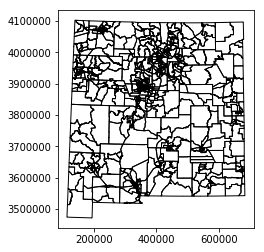

In [3]:
precincts_gdf = gpd.read_file(PRECINCT_SHAPES_PATH, encoding='cp1252', mode='r')
precincts_gdf = precincts_gdf.to_crs('+init=epsg:32613')
print(precincts_gdf.columns)
print(precincts_gdf.head()[['NAME10']])
precincts_gdf.plot(alpha=1, edgecolor='black', color='None', linewidth=1)

Index(['OBJECTID', 'District_N', 'District_1', 'Name', 'geometry'], dtype='object')
  District_N
0          1
1          2
2          3


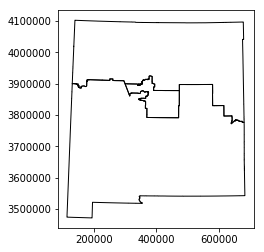

In [4]:
cd_gdf = gpd.read_file(CD_SHAPES_PATH, encoding='cp1252', mode='r')
print(cd_gdf.columns)
print(cd_gdf.head()[['District_N']])
cd_gdf = cd_gdf.to_crs('+init=epsg:32613')
cd_gdf.plot(alpha=1, edgecolor='black', color='None', linewidth=1)

#### Results data

Next we read in the CSV files containing our precinct results. We can inspect the headers of each files to see that they follow identical formats. We can also print out a sample of the data using `.head()` on the dataframes. Further inspection reveals that the files are very similar, but there are two differences we care about: the 2016 results references **party** as either `Democratic` or `Republican` while the 2018 results references them as `DEM` and `REP`, respectively. Also the House of Representatives **office** is specified as `House` in the 2016 results, and as `U.S. House` in the 2018 results.

In [5]:
# read the csv files in as a dataframe
# print out the columns
data_2016 = pd.read_csv(RESULTS_2016_PATH)
print(data_2016.columns)
data_2018 = pd.read_csv(RESULTS_2018_PATH)
print(data_2018.columns)

# print out a sample of data
print('Sample of 2016 data:')
print(data_2016.head()[['county', 'precinct', 'office', 'party', 'votes']])
print('Sample of 2018 data:')
print(data_2018.head()[['county', 'precinct', 'office', 'party', 'votes']])

Index(['county', 'precinct', 'office', 'district', 'party', 'candidate',
       'votes'],
      dtype='object')
Index(['county', 'precinct', 'office', 'district', 'party', 'candidate',
       'votes'],
      dtype='object')
Sample of 2016 data:
       county  precinct office       party  votes
0  Bernalillo         1  House  Republican    316
1  Bernalillo         1  House  Democratic    388
2  Bernalillo         2  House  Republican    283
3  Bernalillo         2  House  Democratic    329
4  Bernalillo         3  House  Republican    352
Sample of 2018 data:
       county  precinct            office party  votes
0  Bernalillo         1  Attorney General   DEM    443
1  Bernalillo         2  Attorney General   DEM    328
2  Bernalillo         3  Attorney General   DEM    464
3  Bernalillo         4  Attorney General   DEM    323
4  Bernalillo         5  Attorney General   DEM    346


## Extract, clean, and calculate data

### Clean the precinct `NAME10` field

Doña Ana County in the precinct shapefile has Windows-1252 (or CP-1252) encoded characters that we're going replace for simplicity with the ASCII Dona Ana County. This will match our results files.

In [6]:
precincts_gdf['NAME10'] = precincts_gdf['NAME10'].map(
    lambda x: '{}{}'.format('Don', x[3:]) if 'Ana County' in x else x
)

### Calculcate and extract the precinct results

Since the two dataframes are similarly structured, we can write a function to calculate and extract the target data. We simply need to provide the source data, and specify which **office**, **party**, and **district** we care about. Once extracted, the function will calculate the percentage results for each candidate, and filter those down to our target **party**. In this case, we are calculating and extracting the vote percentage of the 2016 and 2018 Democratic candidates in each precinct in U.S. House District 2.

We'll also use this opportunity to generate a `NAME10` field on our results that matches the format of our precinct shapefiles. This field is of the format: `{CountyName} County Precinct {PrecinctNumber}`. Having this field present on both our results data and shapefiles will allow us to join the two data sets.

In [7]:
def extract_precinct_data(source_data, office, party, district=''):
        
    # filter it down to the office and district
    filtered_results_df = source_data[
        (source_data['office'] == office) & \
        (source_data['district'] == district)
    ]
    
    # create a full-name precinct column
    filtered_results_df['NAME10'] = filtered_results_df['county'] + \
        ' County Precinct ' + \
        filtered_results_df['precinct'].map(str)
    
    # Get the total votes per precinct
    pc_totals = filtered_results_df['votes'].groupby(
        filtered_results_df['NAME10']
    ).transform('sum')
    filtered_results_df['pc_total'] = pc_totals
    
    # And calculate a percentage for every candidate
    filtered_results_df['vote_percent'] = filtered_results_df['votes'].astype(float) / \
        filtered_results_df['pc_total']

    # filter it down to the target party
    party_filtered_results_df = filtered_results_df[(filtered_results_df['party'] == party)]
    
    return party_filtered_results_df

dem_2016_results_df = extract_precinct_data(data_2016, 'House', 'Democratic', 2)
dem_2018_results_df = extract_precinct_data(data_2018, 'U.S. House', 'DEM', 2)

### Merge the 2016 and 2018 data

Now that we've extracted the data from both election cycles, we can merge the two sets on the `NAME10` field so that they are in a single dataframe.

In [8]:
# join the 2016 and 2018 data
all_results_df = pd.merge(
    dem_2016_results_df,
    dem_2018_results_df,
    on='NAME10',
    how='outer'
)

# clean up our column names
all_results_df.rename(
    columns={
        'vote_percent_x': 'vote_percent_2016',
        'vote_percent_y': 'vote_percent_2018',
    },
    inplace=True
)

### Calculate the 2016 to 2018 Democratic shift

Now with this combined dataframe, we can simply subtract the 2016 precentages from the 2018 percentages of each precinct. This will give us the shift (or delta) or the Democratic results between the two cycles.

In [9]:
# calculate the 2016 -> 2018 D shift
all_results_df['democratic_delta'] = all_results_df['vote_percent_2018'].astype(float) - \
    all_results_df['vote_percent_2016'].astype(float)

print(all_results_df.head()[['NAME10', 'democratic_delta']])

                          NAME10  democratic_delta
0  Bernalillo County Precinct 93          0.320023
1       Catron County Precinct 1          0.114188
2       Catron County Precinct 2          0.024866
3       Catron County Precinct 3          0.065909
4       Catron County Precinct 4          0.050714


### Filter the congressional district shape

Now we can start drawing our data onto the map. First, filter the congressional district shapefiles down to NM-02. We can plot it to be sure it did what we expected.

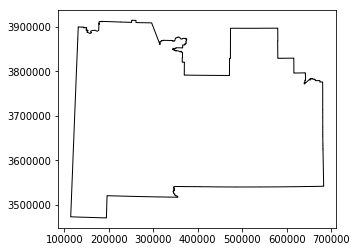

In [10]:
hd_2_gdf = cd_gdf[(cd_gdf['District_N'] == '2')]
hd_2_gdf.plot(alpha=1, edgecolor='black', color='None', linewidth=1)

### Filter the precincts shapes

Filter our precincts down to only those in NM-02. We can reference `all_results_df`'s `NAME10` field since it is already filtered. We can plot it to be sure it did what we expected.

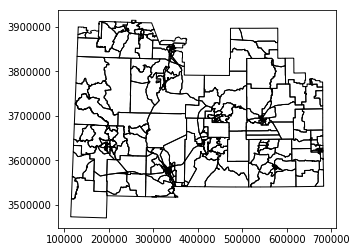

In [11]:
precincts_gdf = precincts_gdf[(
    precincts_gdf['NAME10'].isin(
        all_results_df['NAME10'].tolist()
    )
)]

precincts_gdf.plot(alpha=1, edgecolor='black', color='None', linewidth=1)

### Merge our precinct shapefile with our precinct data

Since we have corresponding cleaned `NAME10` fields on both datasets, we can simply join on that field. The resulting object is a pandas dataframe which we can convert that back to a geodataframe.

In [12]:
merged_gdf = pd.merge(precincts_gdf, all_results_df, on='NAME10', how='outer')
merged_gdf = gpd.GeoDataFrame(merged_gdf, crs=precincts_gdf.crs)

### Split the precincts by shift

Now we'll break up our precincts by which way they shifted from 2016 to 2018: Democratic, Republican, or no shift. For the Republican shifts, convert our data from a negative Democratic shift to a positive Republican shift.

In [13]:
blue_shift_gdf = merged_gdf[merged_gdf['democratic_delta'] > 0]
blue_shift_gdf = gpd.GeoDataFrame(blue_shift_gdf, crs=merged_gdf.crs)

no_shift_gdf = merged_gdf[merged_gdf['democratic_delta'] == 0]
no_shift_gdf = gpd.GeoDataFrame(no_shift_gdf, crs=merged_gdf.crs)

red_shift_gdf = merged_gdf[merged_gdf['democratic_delta'] < 0]
red_shift_gdf = gpd.GeoDataFrame(red_shift_gdf, crs=merged_gdf.crs)
# Convert the negative Democratic deltas to positive Republican deltas
red_shift_gdf.rename(columns={'democratic_delta': 'republican_delta'}, inplace=True)
red_shift_gdf['republican_delta'] = red_shift_gdf['republican_delta'].abs()

## Draw

We're now ready to draw our results to the map. First, set up the canvass. We'll also set up a `kwargs` variable to define the range for our precinct coloring gradients.

From there we can draw our precincts.

Text(0.5, 1.0, 'NM-02 U.S. House Democratic 2016 to 2018 Shift\nBy Precinct')

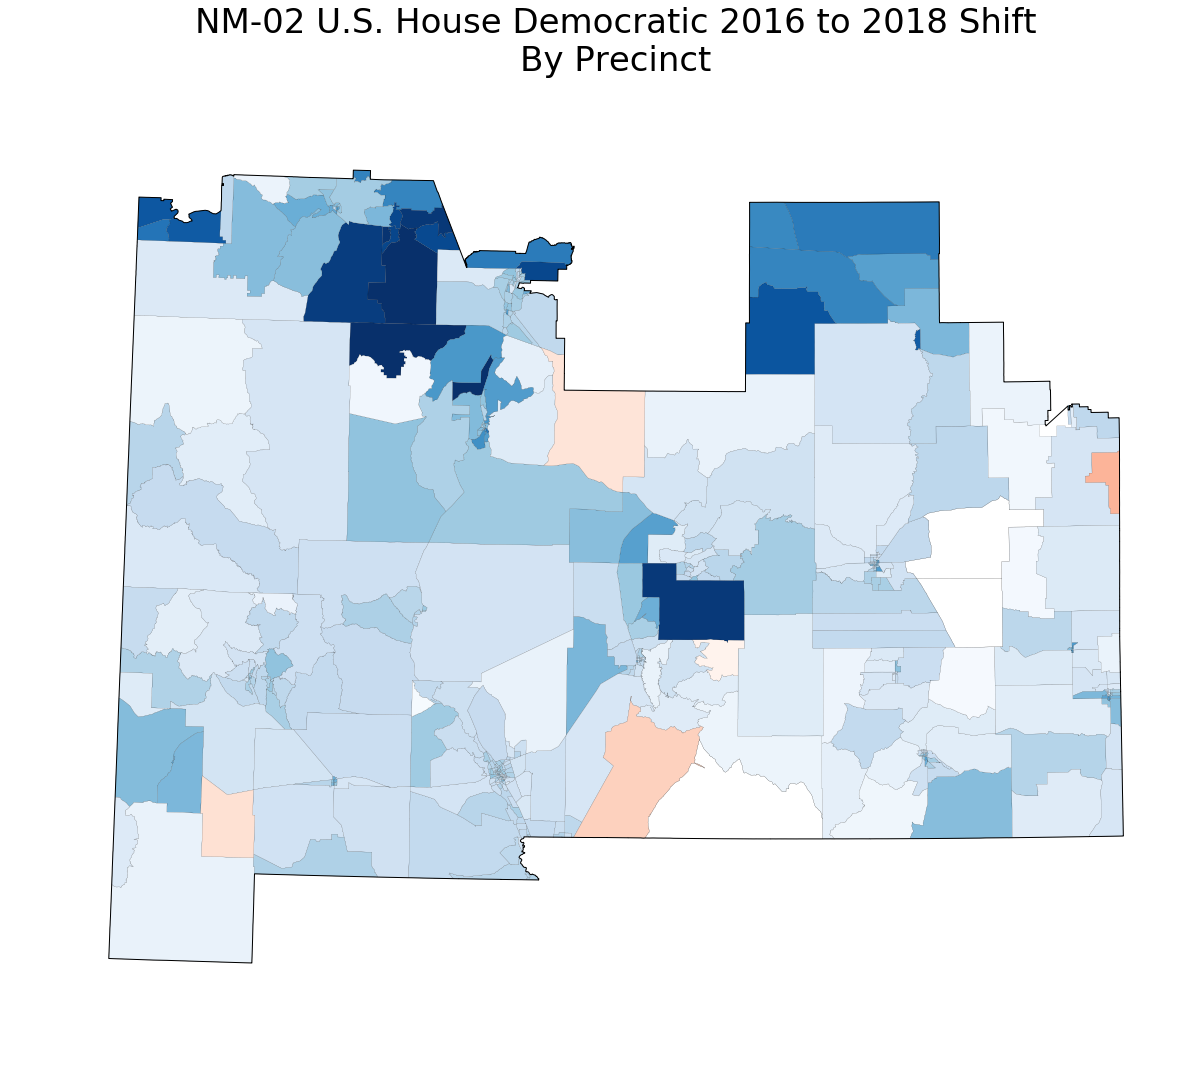

In [14]:
fig, ax0 = plt.subplots(figsize=(20, 18))  # main canvass

# turn off the axes and gridlines
ax0.set_axis_off()
ax0.axis('equal')

kwargs = {
    'vmax': 0.45,
    'vmin': 0,
}

# draw blue-shift precincts, colored by `democratic_delta`
blue_shift_gdf.plot(
    ax=ax0,
    alpha=1,
    cmap='Blues',
    edgecolor='black',
    column='democratic_delta',
    linewidth=0.1,
    **kwargs
)

# draw red-shift precincts, colored by `republican_delta`
red_shift_gdf.plot(
    ax=ax0,
    alpha=1,
    cmap='Reds',
    edgecolor='black',
    column='republican_delta',
    linewidth=0.1,
    **kwargs
)

# draw no-shift precincts, no color
no_shift_gdf.plot(
    ax=ax0,
    alpha=1,
    color='None',
    edgecolor='black',
    linewidth=0.1
)

# draw NM-02 outline
hd_2_gdf.plot(
    ax=ax0,
    alpha=1,
    edgecolor='black',
    color='None',
    linewidth=1
)

# draw title
title = 'NM-02 U.S. House Democratic 2016 to 2018 Shift\nBy Precinct'
ax0.set_title(title, fontsize=34)